In [2]:
import bagpipes as pipes
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
import cosmos
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from ReadFilters import *
import getpass
from lmfit import Model

## Define the essential functions to produce SEDs

In [23]:
def model_gauss(X,Cont1,Peak1,Mu1,Sigma1):
	Wave = X
	return Cont1 + Peak1 * np.exp(-(Wave-Mu1)**2/(2*Sigma1**2))

def EmissionLineFits(z,Xwave_obs,Xflux,wave_line,name_line):
	x = Xwave_obs 
	y = Xflux * 1.e19
	err = y*0.1         # assume 10% error
	whts = 1./ err**2   # 1 / variance
	whts = y * 0.0 + 1  # equal weights
	for l in range(0,len(wave_line)):
		wobs = wave_line[l] * (1+z)
		if wobs >= x[0]+50. and wobs <= x[-1]-50.:
			mod = Model(model_gauss) 
			pars = mod.make_params()
			pars.add('Cont1',value=10.,min=0.,max=1.e3)
			pars.add('Peak1',value=100.,min=0.0,max=1.e6)
			pars.add('Mu1',value=wobs,min=wobs-5,max=wobs+5)
			pars.add('Sigma1',value=10.0,min=1.0,max=100.0)
			print(pars)
			print('Fitting line ', name_line[l])
			tmp_result = mod.fit(y, pars, X=(x), weights=whts)
			chi_squared = tmp_result.chisqr
			reduced_chi_squared = tmp_result.redchi
			cont = tmp_result.values['Cont1'] * 1.e-19
			peak = tmp_result.values['Peak1'] * 1.e-19
			mu = tmp_result.values['Mu1']
			redshift = mu/wave_line[l] - 1.
			sigma = tmp_result.values['Sigma1']
			fwhm_obs = 2.355 * sigma
			fwhm_rest = fwhm_obs / (1. + redshift)
			fwhm_kms = fwhm_obs * 3e5 / wobs
			flux = peak * sigma * np.sqrt(2*np.pi)
			print("Continuum: ", cont)
			print("Peak flux: ", peak)
			print("Line flux: ", flux)
			print("Observed Wavelength: ", mu, " Angstrom")
			print("redshift: ", redshift)
			print("Observed Width (FWHM; Angstrom): ", fwhm_obs)
			print("Rest Width (FWHM; Angstrom): ", fwhm_rest)
			print("Rest Width (FWHM; km/s): ", fwhm_kms)
	return cont, peak, flux, mu, sigma, redshift, fwhm_obs, fwhm_kms

def getMags(Wave,Spectrum,N_filters,FilterCurves,FilterLength,FilterType):
	Mags = np.empty(N_filters)
	Mags.fill(0)
	intmode = 0
	cLight = 3.e18
	for filter in range(0,N_filters):
		int_upper = 0.
		int_lower = 0.
		TmpFilter = FilterCurves[filter,:,:]
		TmpFilter = TmpFilter[0:FilterLength[filter],:]
		
		lmin = TmpFilter[0,0]
		lmax = np.max(TmpFilter[:,0])
		l1 = np.where(np.greater(Wave,lmin))[0]
		l2 = np.where(np.less(Wave,lmax))[0]
		if len(l1) != 0 and len(l2) != 0:
	
			if intmode == 0:
		#interpolate filter on a grid of 10,000 points between the minimum and maximum wavelength of the filter
				npoints = 10000
				dl = (lmax-lmin)/npoints
				TmpWave = np.arange(npoints,dtype=float) * dl + lmin
				TmpFilterInterp = np.interp(TmpWave,TmpFilter[:,0],TmpFilter[:,1])
				#interpolate the SED on the same wavelength grid as the filter
				TmpSpectrum = np.interp(TmpWave,Wave,Spectrum)

			if intmode == 1:
		#interpolate filter on the wavelength grid, where the first point of the grid is the first point for which Lambda_SSP > Lambda_Filter_min 
		#and the last point the largest Lambda_SSP for which Lambda_SSP < Lambda_Filter_Max
				TmpWave = Wave[l1[0]:l2[-1]+1] 
				TmpSpectrum = Spectrum[l1[0]:l2[-1]+1]
				TmpFilterInterp = np.interp(TmpWave,TmpFilter[:,0],TmpFilter[:,1])

			if FilterType[filter] == 'ccd':
			#Lower and upper Integral of the magnitude determination function for a photon counting device and an input spctrum in f_lambda in erg/s/cm2/A
				int_upper = np.trapz(TmpFilterInterp*TmpSpectrum*TmpWave,x=TmpWave)
				int_lower = cLight * np.trapz(TmpFilterInterp/TmpWave,x=TmpWave)
			if int_lower != 0 and int_upper != 0:
				Mags[filter] = -2.5 * np.log10(int_upper/int_lower) - 48.6
			else:
				Mags[filter] = 99.
	
		else:
			Mags[filter] = 99.
	return Mags

def Lum2FluxFac(Dlum_cm,redshift,lum_units):
	FluxFac = 1. / ( 4 * np.pi * pow(Dlum_cm,2))
	if lum_units == 'lambda':
		FluxFac = FluxFac / (1. + redshift) 
	elif lum_units == 'nu':
		FluxFac = FluxFac * (1. + redshift)  
	elif lum_units == 'line':
		FluxFac = FluxFac
	return FluxFac

def greeneho2005_lum(mbh,fwhm):
	lum42 = (mbh / (fwhm/1000.)**2.06 / 2e6)**(1/0.55)
	lum = lum42 * 1e42
	return lum

def greeneho2005_mbh(lum,fwhm):
	mbh = 2e6 * (lum/1e42)**0.55 * (fwhm/1000.)**2.06
	return mbh

def greeneho2005_fwhm(mbh,lum):
	fwhm3 = (mbh / (lum/1.e42)**0.55 / 2e6)**(1/2.06)
	fwhm = fwhm3 * 1000.
	return fwhm

def greeneho2005_L5100(Lha):
	# from Greene & Ho (2005)
	L5100 = 1e44 * (Lha/5.25e42)**(1./1.157)
	return L5100

def Calzetti_ExCurve(WaveLength):
	Speclen = len(WaveLength)
	ExCurve = np.empty(Speclen)
	rv = 4.05
	c_short = [2.659,-2.156,1.509,-0.198,0.011]
	c_long = [2.659,-1.857,1.04]
	a = np.where(WaveLength >= 6300.)
	WaveLengthMicron = WaveLength / 1.e4
	if len(a[0]) > 0:
		a = a[0][0]
		ExCurve[0:a] = c_short[0] * (c_short[1] + c_short[2]/WaveLengthMicron[0:a] + c_short[3]/pow(WaveLengthMicron[0:a],2) + c_short[4]/pow(WaveLengthMicron[0:a],3)) + rv
		ExCurve[a:Speclen] = c_long[0] * (c_long[1] + c_long[2]/WaveLengthMicron[a:Speclen]) + rv
	else:
		ExCurve[0:Speclen] = c_short[0] * (c_short[1] + c_short[2]/WaveLengthMicron[0:Speclen] + c_short[3]/pow(WaveLengthMicron[0:Speclen],2) + c_short[4]/pow(WaveLengthMicron[0:Speclen],3)) + rv
	return ExCurve

def Calzetti(wave,flux,ebv,direction):
	if ebv > 0:
		curve_calz = Calzetti_ExCurve(wave)

		plotthis = 0
		if plotthis == 1:
			plt.figure(figsize=(6.5, 4))
			plt.plot(wave, curve_calz, '-')
			plt.title('Effective extinction law: Q_e(lambda) (Calzetti et al. 2001)')
			plt.xlabel('Wavelength (A)')
			plt.ylabel('k(lambda)')
			plt.show()
	
		#Now apply extinction correction to input flux vector:
		if direction == 'redden':
			sign = -1.0
		if direction == 'unredden':
			sign = 1.0
		flux_new = flux * (10.**(0.4*sign*ebv*curve_calz)) #Here flux is unreddened by the Milky Way
	
		return flux_new
	else:
		return flux

def gaus_emline(x,b,x0,sigma):
	return b * np.exp(-(x-x0)**2/(2*sigma**2))

def ConvolveSpec(Flux,FWHM):
	Gauss = Gaussian1DKernel(stddev=FWHM)
	Flux_Conv = cnv.convolve(Flux, Gauss, boundary='extend')
	return Flux_Conv

def read_cloudy(file):
	cnt = 0
	with open(file, "r") as f:
		while True:
			line = f.readline()
			cnt += 1
			if len(line) == 0:
				break # end of file
	lines = []
	f =  open(file,"r")
	for i in range(0,cnt):
		line = f.readline()
		lines.append(line)
	f.close()
	return lines

def get_lines_from_cloudy(cloudy_file, cloudy_linelist):
	raw_output = read_cloudy(cloudy_file)
	lines = Table.read(cloudy_linelist, format="csv", comment='#')  
	lines['lam'] = 0.
	lines['lum'] = 0.
	lines['flux'] = 0.
	# parse the cloudy output file and find the line ratios
	for j in range(0,len(lines)):
		id = lines['label'][j]
		id_split = id.split()
		lines['lam'][j] = np.float_(id_split[-1].strip("A"))
		for i in range(0,len(raw_output)):
			str = raw_output[i]
			flds = str.split()
			for k in range(0,len(flds)-4):
				if id_split[0:3] == flds[k:k+3]: 
					lines['lum'][j] = np.float_(flds[k+3])
					lines['flux'][j] = np.float_(flds[k+4])

	# sort on wavelength and scale to Ha = 1
	lines.sort('lam')
	lines['flux'] = lines['flux']/100.
	return lines

def get_nebcont_from_cloudy(cloudy_file):
	raw_output = read_cloudy(cloudy_file)
	nebcont = Table(names=('label','lam_string','lam','lum','lamflam','flam'),dtype=('S10','S10','f4','f4','f4','f4'))
	# parse the cloudy output file and find the nebular continuum values
	for i in range(0,len(raw_output)):
		str = raw_output[i]
		flds = str.split()
		if len(flds) >= 4:
			#find the rows that start with nFnu but exclude the two Balmer cont. values at the beginning of the table
			if flds[0] == 'nFnu' and flds[1] != '3645.00A' and flds[1] != '3647.00A': 
				wav_units = flds[1][-1]
				if wav_units == 'A':
					wav_multiply = 1.0
				elif wav_units == 'm':
					wav_multiply = 1.e4
				if wav_units == 'c':
					wav_multiply = 1.e8
				wav_Angstrom = np.float_(flds[1][0:-1]) * wav_multiply
				lum = np.float_(flds[2])
				lamflam = np.float_(flds[3])
				flam = np.float_(flds[3]) / wav_Angstrom
				nebcont.add_row((flds[0],flds[1],wav_Angstrom,lum,lamflam,flam))
	# scale to Ha = 1
	nebcont['lamflam'] = nebcont['lamflam']/100.
	nebcont['flam'] = nebcont['flam']/100.
	return nebcont

def make_line_spectrum(emlines,hascl,fwhmkms,z,lam_obs):
	linespec = lam_obs * 0.0
	for i in range(0,len(emlines)):
		wobs = emlines['lam'][i] * (1.+z)
		if wobs > lam_obs[0] and wobs < lam_obs[-1]:
			fline = emlines['flux'][i]
			fwhm_obs_angstrom = fwhmkms * wobs / 3.e5
			sigma_obs_angstrom = fwhm_obs_angstrom / 2.355
			hline = fline / np.sqrt(2*np.pi) / sigma_obs_angstrom
			gline = gaus_emline(lam_obs,hline,wobs,sigma_obs_angstrom)
			linespec = linespec + gline
	linespec = linespec * hascl
	return linespec

def print_info_block():
	print()
	print("Structure of the 'results' output array:")
	print(" 0 - observed wavelengths (Angstroms)")
	print(" 1 - rest wavelengths (Angstroms)")
	print(" 2 - host spectrum (erg/s/cm2/Angstrom)")
	print(" 3 - NLR line spectrum")
	print(" 4 - NLR nebular continuum spectrum")
	print(" 5 - NLR (lines+nebcont) spectrum")
	print(" 6 - dusty NLR (lines+nebcont) spectrum")
	print(" 7 - host + NLR (lines+nebcont) spectrum")
	print(" 8 - host + dusty NLR (lines+nebcont) spectrum")
	print(" 9 - scattered BLR spectrum")
	print("10 - host + dusty NLR + scattered BLR spectrum")
	print("11 - scattered AGN continuum spectrum")
	print("12 - BLR + scattered AGN continuum spectrum")
	print("13 - host + dusty NLR + BLR + scattered AGN continuum spectrum")
	print()
	return 0

def nirspec_ifu_wavelength_gaps(working_path,ax,yval):
	gaps = Table.read(working_path + 'nirspec-ifu_gaps.csv', format="csv", comment='#')  
	for i in range(0,len(gaps)):
		ax.plot([gaps['G235H_MIN'][i],gaps['G235H_MAX'][i]],[yval+1e-19*i,yval+1e-19*i],'b',lw=1)
		ax.plot([gaps['G395H_MIN'][i],gaps['G395H_MAX'][i]],[yval+1e-19*i,yval+1e-19*i],'r',lw=1)
	return 0

def nirspec_ifu_wavelength_ranges(working_path,ax,yval):
	ranges = Table.read(working_path + 'nirspec-ifu_dispersers.csv', format="csv", comment='#')  
	gaps = Table.read(working_path + 'nirspec-ifu_gaps.csv', format="csv", comment='#')  
	for i in range(0,len(ranges)):
		if ranges['combo'][i] == 'G235H/F170LP':
			ax.plot([ranges['lmin_mu'][i],ranges['lmax_mu'][i]],[yval*0.8,yval*0.8],'0.5',lw=10,zorder=1)
		if ranges['combo'][i] == 'G395H/F290LP':
			ax.plot([ranges['lmin_mu'][i],ranges['lmax_mu'][i]],[yval,yval],'0.5',lw=10,zorder=1)			
	# plot the gap range
	min_235h = np.min(gaps['G235H_MIN'])
	max_235h = np.max(gaps['G235H_MAX'])
	min_395h = np.min(gaps['G395H_MIN'])
	max_395h = np.max(gaps['G395H_MAX'])
	ax.plot([min_235h,max_235h],[yval*0.8,yval*0.8],'k',lw=10,zorder=2)
	ax.plot([min_395h,max_395h],[yval,yval],'k',lw=10,zorder=2)
	#for i in range(0,len(gaps)):
	#	ax.plot([gaps['G235H_MIN'][i],gaps['G235H_MAX'][i]],[yval*0.8+1e-19*i,yval*0.8+1e-19*i],'b',lw=1,zorder=2)
	#	ax.plot([gaps['G395H_MIN'][i],gaps['G395H_MAX'][i]],[yval*0.8+1e-19*i,yval*0.8+1e-19*i],'r',lw=1,zorder=2)
	return 0


## Set up the key modeling parameters

In [24]:
# YOUR PATH
if getpass.getuser() == "aayushsaxena":
    working_path = "/Users/aayushsaxena/Desktop/UCL/JWST-prep/spectrasims/"
elif getpass.getuser() == "roderik":
    working_path = "/Users/roderik/Dropbox/Proposals_recent/JWST/Cycle1/JWST-HzRGs/"
    
# IN PRINCIPLE NO NEED TO CHANGE THIS
cloudy_output_path = working_path + "CLOUDY/"
filter_path = working_path + "FILTER/"
other_filters_path = filter_path
nircam_filters_path = filter_path + "NIRCAM/modAB_mean/nrc_plus_ote/"
miri_filters_path = filter_path + "MIRI/"

# COSMOLOGY
cosmo_pars = [0.3,0.7,0.0,0.7]  # O_M, O_L, O_K, h (these parameters now match those from Carnall et al. 2018 where Bagpipes is described)

# HOST GALAXY
set_host = 'TGSS1530_1'
#set_host = 'TN1338_1'

if set_host == 'TGSS1530_1':
    z = 5.72               # source redshift
    stellarmass = 5e10    # Msun
    veldisp = 300.         # Velocity dispersion: km/s
    metallicity = 0.5      # # Z/Z_solar
    age = 0.8              # Time since SF switched on: Gyr (needed for: constant and exp sfh)
    sfr_stop = 0.0         # Time since SF switched off: Gyr (needed for: constant sfh)
    sfh = 'constant'       # alternative: 'exp'
    tau = 1.5              # tau (needed for: exp sfh)
    host_dust = "Calzetti" # shape of the attenuation curve
    host_dust_burst = 2    # extra dust for young stars: multiplies Av
    host_EBV = 0.2         # note: AV = RV * E(B-V), with RV = 4.05 for Calzetti
    agn_mbh = 1.e9         # Msun

if set_host == 'TN1338_1':
    z = 4.11               # source redshift
    stellarmass = 1.e11    # Msun
    veldisp = 300.         # Velocity dispersion: km/s
    metallicity = 1.0      # # Z/Z_solar
    age = 1.3              # Time since SF switched on: Gyr (needed for: constant and exp sfh)
    sfr_stop = 0.0         # Time since SF switched off: Gyr (needed for: constant sfh)
    sfh = 'constant'       # alternative: 'exp'
    tau = 1.5              # tau (needed for: exp sfh)
    host_dust = "Calzetti" # shape of the attenuation curve
    host_dust_burst = 2    # extra dust for young stars: multiplies Av
    host_EBV = 0.2         # note: AV = RV * E(B-V), with RV = 4.05 for Calzetti
    agn_mbh = 1.e9         # Msun

# FILTERS
filt_list = [other_filters_path + 'VLTJ2.res', \
             other_filters_path + 'VLTH2.res', \
             other_filters_path + 'VLTKs2.res', \
             nircam_filters_path + 'F277W_NRC_and_OTE_ModAB_mean.txt', \
             nircam_filters_path + 'F356W_NRC_and_OTE_ModAB_mean.txt', \
             nircam_filters_path + 'F444W_NRC_and_OTE_ModAB_mean.txt'] # desired filters
filt_units = [1,1,1,1e4,1e4,1e4] # conversion factors to convert all filters to Angstroms
filt_shortname = ['J','H','Ks','F277W','F356W','F444W']

# CLOUDY AGN MODEL
cloudy_output_file = 'agn2.out'   # Cloudy model file for the AGN spectrum 
cloudy_linelist = 'agn_lines_wanted.csv'    # list of emission lines to be included in the AGN spectrum
agn_haflux = 1.e-17    # erg/s/cm2 # change to luminosity???      
agn_ebv_gas = 0.2      # mag
agn_fwhmkms = 1000.    # km/s
agn_alpha = 1.         # fnu propto nu**-alpha

# BROAD EMISSION LINES
agn_fhahb = 4.5        # broad Ha/Hb flux ratio empirical, observed flux ratio of the broad components; intrinsic=3.1 with AV=1; Nesvadba et al. (2011); agrees with Osterbrock Table 12.4
agn_fhamg2 = 3.3        # taken from Osterbrock Table 12.4
agn_fwhmbroad = 10000. # km/s
agn_scattered_fraction = 0.05  # assumed fraction of the broad line scattered

# WAVELENGTH RANGES
lam_obs_min = 10000.   # Angstrom; minimum observed wavelength of the simulated spectrum
lam_obs_max = 53000.   # Angstrom; maximum observed wavelength of the simulated spectrum

### Derived parameters
# parameters directly derived from the input parameters
logstellarmass = np.log10(stellarmass)
host_Av = host_EBV * 4.05
lam_rest_min = lam_obs_min / (1+z)                # minimum rest wavelength of the simulated spectrum 
lam_rest_max = lam_obs_max / (1+z)                # maximum rest wavelength of the simulated spectrum 
lam_obs = np.arange(lam_obs_min,lam_obs_max,1.)   # observed wavelength axis for the generated spectra, delta_lam = 1A !!!
lam_rest = lam_obs / (1.+z)                       # rest-frame spectrum
lam_rest_min = lam_rest[0]                        # minimum rest wavelength of the simulated spectrum 
lam_rest_max = lam_rest[-1]                       # maximum rest wavelength of the simulated spectrum 
results = np.zeros((len(lam_obs),14))             # this array will hold the resulting spectra
# calculate the luminosity distance in cm
cosmodata = cosmos.cosmologicaldata(cosmo_pars[0],cosmo_pars[1],cosmo_pars[2],cosmo_pars[3],z)
cosmodata.calculate()
Dlum_Mpc = cosmodata['DL'] 
Mpc2cm = 3.08568025 * pow(10,24) # Mpc to cm conversion, assuming DLUM is in Mpc not Mpc/h!
Dlum_cm = Dlum_Mpc * Mpc2cm      # luminosity distance in cm

In [25]:
### FILTERS
# read the filter curves
FilterFile = working_path + 'filters.lst'
f = open(FilterFile,"w")
for k in range(0,len(filt_list)):
	f.write(filt_list[k]+' ccd'+'\n')
f.close()
FilterNames, FilterCurves, FilterType, FilterLen, N_filters, FilterWaves = ReadFilters(FilterFile,filt_units)

Importing Filter Data


## Set up the Bagpipes SED model

Option to turn the nebular emission lines on and off

In [26]:
### SET UP BAGPIPES MODEL

# set up the star formation history
sfh_pars = {} 
sfh_pars["age_max"] = age      
sfh_pars["massformed"] = logstellarmass
sfh_pars["metallicity"] = metallicity          

if sfh == 'constant':                     
	sfh_pars["age_min"] = sfr_stop      
	sfh_pars["massformed"] = logstellarmass
	sfh_pars["metallicity"] = metallicity

if sfh == 'exp':
	sfh_pars.pop("age_max")                      
	sfh_pars["age"] = age                  
	sfh_pars["tau"] = tau                 

# set up the host dust component
dust = {}                         
dust["type"] = host_dust         
dust["Av"] = host_Av                  
dust["eta"] = host_dust_burst      

# set up the model components dictionary for the host galaxy
model_components = {}                   
model_components["redshift"] = z        
model_components[sfh] = sfh_pars
model_components["dust"] = dust
model_components["veldisp"] = veldisp

### nebular emission lines - comment this bit of code to not use nebular lines
nebular = {}                      # Nebular emission component
nebular["logU"] = -2.             # log_10(ionization parameter)


model_components["t_bc"] = 0.01    # Lifetime of birth clouds (Gyr)
model_components["veldisp"] = 300.    # km/s
model_components["nebular"] = nebular

print("Bagpipes parameters loaded, proceed to spectrum creation.")

Bagpipes parameters loaded, proceed to spectrum creation.


In [27]:
# create the host SED spectrum
model = pipes.model_galaxy(model_components, spec_wavs=lam_obs)
host_spectrum = model.spectrum
host_sfh = model.sfh
# collect some results
results[:,0] = host_spectrum[:,0] # observed wavelengths
results[:,1] = lam_rest           # rest wavelengths
results[:,2] = host_spectrum[:,1] # host spectrum (including extinction?)

print("Bagpipes SED created!")

Bagpipes SED created!


## AGN emission

In [28]:
# get the AGN emission lines from Cloudy
emlines = get_lines_from_cloudy(cloudy_output_path + cloudy_output_file, cloudy_output_path + cloudy_linelist)
line_spec = make_line_spectrum(emlines,agn_haflux,agn_fwhmkms,z,lam_obs)
results[:,3] = line_spec          # AGN narrow line spectrum from Cloudy

# NOTE THIS THIS IS NOT WORKING PROPERLY. WE MULTIPLY THE NEB CONT SPECTRUM BY 0.0 TO TURN IT OFF!!!
# get the AGN nebular continuum from Cloudy 
nlrcont = get_nebcont_from_cloudy(cloudy_output_path + cloudy_output_file)
nlrcont['flam'] = nlrcont['flam'] * agn_haflux   # scale to the Ha line flux (Cloudy result is relative to Ha=1)
# interpolate on the object spectrum wavelength grid
nlrcont_interp = lam_rest*0.0 
cont_lam = np.array(nlrcont['lam'])
cont_flam = np.array(nlrcont['flam'])
for i in range(0,len(lam_rest)):
	nlrcont_interp[i] = np.interp(lam_rest[i],cont_lam,cont_flam)
results[:,4] = nlrcont_interp*0.0      # AGN nebular continuum spectrum from Cloudy 

# sum the AGN nebular line and continuum spectrum
results[:,5] = results[:,3] + results[:,4] # AGN narrow line spectrum + nebcont (no dust)

# apply Calzetti reddening to AGN nebular spectrum
results[:,6] = Calzetti(lam_rest,results[:,5],agn_ebv_gas,'redden')

# sum the host + AGN spectrum (line & neb. cont)
results[:,7] = results[:,2] + results[:,5] 

# sum the host + dusty AGN spectrum (line & neb. cont)
results[:,8] = results[:,2] + results[:,6] 

# create the broad components of Ha and Hb
lum_broad_Ha = greeneho2005_lum(agn_mbh,agn_fwhmbroad)
flux_broad_ha = lum_broad_Ha * Lum2FluxFac(Dlum_cm, z, "line")
flux_broad_ha_scattered = flux_broad_ha * agn_scattered_fraction
flux_broad_hb_scattered = flux_broad_ha_scattered / agn_fhahb
flux_broad_mg2a_scattered = flux_broad_ha_scattered / agn_fhamg2 / 2.
flux_broad_mg2b_scattered = flux_broad_ha_scattered / agn_fhamg2 / 2.
broadlines = emlines[0:4]
broadlines['label'][0] = 'H  1      6562.81A'
broadlines['lam'][0] = 6562.81
broadlines['flux'][0] = flux_broad_ha_scattered
broadlines['label'][1] = 'H  1      4861.33A'
broadlines['lam'][1] = 4861.33
broadlines['flux'][1] = flux_broad_hb_scattered
broadlines['label'][2] = 'Mg 2      2795.53A'
broadlines['lam'][2] = 2795.53
broadlines['flux'][2] = flux_broad_hb_scattered
broadlines['label'][3] = 'Mg 2      2802.71A'
broadlines['lam'][3] = 2802.71
broadlines['flux'][3] = flux_broad_hb_scattered
broadline_spec = make_line_spectrum(broadlines,1.0,agn_fwhmbroad,z,lam_obs)
results[:,9] = broadline_spec

# sum the broad line spectrum to host and NLR region
results[:,10] = results[:,8] + results[:,9]

# create the scattered AGN continuum
L5100 = greeneho2005_L5100(lum_broad_Ha)            # integrated flux at 5100A; f5100 = 5100A * F5100_lambda
print("Luminosity of the AGN continuum at 5100A in erg/s: ", L5100)
f5100_lambda = L5100 / 5100. / (4*np.pi*Dlum_cm**2) / (1.+z)   # flam in erg/s/cm2/A
flam_rest = (3.e18)**2 * lam_rest**(agn_alpha-2)
sel5100 = ( np.abs(lam_rest-5100.) == np.min(np.abs(lam_rest-5100.)))   # location of lambda = 5100A
flam_rest = flam_rest/flam_rest[sel5100]
flam_rest_scl = flam_rest * f5100_lambda * agn_scattered_fraction       # this should be total scattered AGN continuum contribution
sel1216 = ( np.abs(lam_rest-1216.) == np.min(np.abs(lam_rest-1216.)))   # location of lambda = 1216A
flam_rest_scl[sel1216] = 0.                                             # remove everything below Lya
results[:,11] = flam_rest_scl

# sum the broad line spectrum and the scattered continuum
results[:,12] = results[:,9] + results[:,11]

# sum the host, the NLR, the broad line spectrum and the scattered continuum
results[:,13] = results[:,8] + results[:,12]

print("AGN narrow lines, nebular continuum (*not) and scattered broad lines and continuum created!")

Luminosity of the AGN continuum at 5100A in erg/s:  2.408133182456205e+44
AGN narrow lines, nebular continuum (*not) and scattered broad lines and continuum created!


In [29]:
# print the contents of the results array for reference
print_info_block()


Structure of the 'results' output array:
 0 - observed wavelengths (Angstroms)
 1 - rest wavelengths (Angstroms)
 2 - host spectrum (erg/s/cm2/Angstrom)
 3 - NLR line spectrum
 4 - NLR nebular continuum spectrum
 5 - NLR (lines+nebcont) spectrum
 6 - dusty NLR (lines+nebcont) spectrum
 7 - host + NLR (lines+nebcont) spectrum
 8 - host + dusty NLR (lines+nebcont) spectrum
 9 - scattered BLR spectrum
10 - host + dusty NLR + scattered BLR spectrum
11 - scattered AGN continuum spectrum
12 - BLR + scattered AGN continuum spectrum
13 - host + dusty NLR + BLR + scattered AGN continuum spectrum



0

In [30]:
# calculate magnitudes in the filters
sedmags = getMags(results[:,0],results[:,13],N_filters,FilterCurves,FilterLen,FilterType)
print()
print("Photometry in AB mag:")
for m in range(0,len(sedmags)):
	print(filt_shortname[m], ' ', sedmags[m])
print()


Photometry in AB mag:
J   25.75321099946961
H   25.499332735513683
Ks   25.094726286930715
F277W   24.21872726043872
F356W   23.6762419276289
F444W   23.54814854425579



## Plotting

In [31]:
# OUTPUT PREFERENCES
plot_wavelength_units = 'micron'  # microns or angstrom 
lam_units = 1.0                   # default in angstrom
if plot_wavelength_units == 'micron':
	lam_units = 1.e-4             # conversion factor to get micron
PlotRanges = 1         # overplot the nirspec/ifu wavelength ranges and gaps
PlotFilters = 1        # overplot the filter transmission curves
PlotMags = 1           # overplot the calculated magnitudes
second_topaxis = 1     # rest-frame wavelength axis
xfigsize = 12          # width of output figure
yfigsize = 5           # height of output figure
interactive = 'no'     # interactive plot

/Users/roderik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Parameters([('Cont1', <Parameter 'Cont1', 10.0, bounds=[0.0:1000.0]>), ('Peak1', <Parameter 'Peak1', 100.0, bounds=[0.0:1000000.0]>), ('Mu1', <Parameter 'Mu1', 44102.0832, bounds=[44097.0832:44107.0832]>), ('Sigma1', <Parameter 'Sigma1', 10.0, bounds=[1.0:100.0]>)])
Fitting line  Ha
Continuum:  8.406618489997797e-22
Peak flux:  3.4013909527841335e-20
Line flux:  5.9965828854723594e-18
Observed Wavelength:  44102.083319798934  Angstrom
redshift:  5.720000018254213
Observed Width (FWHM; Angstrom):  165.6335331687661
Rest Width (FWHM; Angstrom):  24.64784713077962
Rest Width (FWHM; km/s):  1126.7055056172455


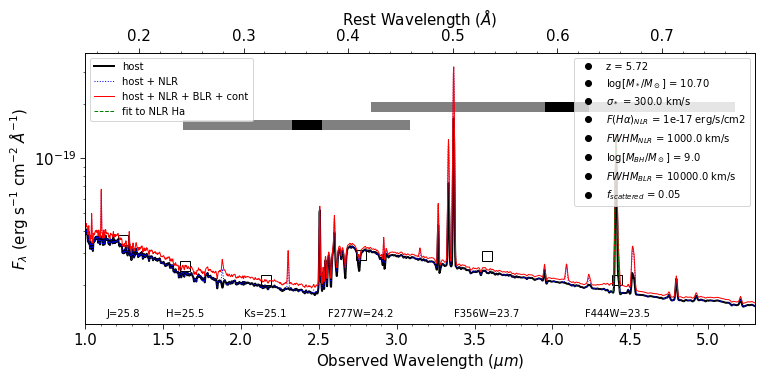

In [32]:
if interactive == 'yes':
    %matplotlib notebook
else:
    %matplotlib inline

# plot things
fig, ax1 = plt.subplots(figsize=(xfigsize, yfigsize))

# plotting limits
ax1.set_xlim(lam_obs_min*lam_units,lam_obs_max*lam_units)
sel = np.logical_and((results[:,0]*lam_units > lam_obs_min*lam_units),(results[:,0]*lam_units < lam_obs_max*lam_units))
fmin = np.min(results[sel,2])*0.8
fmax = np.max(results[sel,13])*1.2
ax1.set_ylim(fmin,fmax)
ax1.set_yscale('log')

# plot the spectra
ax1.plot(results[:,0]*lam_units,results[:,2],'k',lw=2,label='host',zorder=10)
ax1.plot(results[:,0]*lam_units,results[:,8],'b:',lw=1,label='host + NLR',zorder=20)
#ax1.plot(results[:,0]*lam_units,results[:,10],'c-',lw=1,label='host + NLR + BLR',zorder=30)
ax1.plot(results[:,0]*lam_units,results[:,13],'r-',lw=1,label='host + NLR + BLR + cont',zorder=40)

# TEST: fit the narrow Ha emission line and overplot
subt = results[:,8] - results[:,2]  # since we are not fitting the host spectrum, just fit the host-subtracted NLR spectrum
c1,p1,f1,m1,s1,z1,fwhm_obs1,fwhm_kms1 = EmissionLineFits(z,results[:,0],subt,[6562.81],['Ha'])
yfit = model_gauss(results[:,0],c1*0.,p1,m1,s1) + results[:,2] # make the best-fit Gaussian and add back the host spectrum
sel = np.logical_and(np.greater_equal(results[:,0],(1.+z)*6563-250),np.less_equal(results[:,0],(1.+z)*6563+250))
ax1.plot(results[sel,0]*lam_units,yfit[sel],'g--',lw=1,label='fit to NLR Ha',zorder=50)

# plot the legend for the spectra
ax1.legend(loc='upper left')

# labels, ticks and secondary axis	
ax1.tick_params(axis='both', which='major', labelsize=15)
if plot_wavelength_units == 'angstrom': 
	ax1.set_xlabel('Observed Wavelength ($\AA$)',fontsize=15)
elif plot_wavelength_units == 'micron': 
	ax1.set_xlabel('Observed Wavelength ($\mu m$)',fontsize=15)
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)',fontsize=15)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='minor', length=2, color='k')
ax1.tick_params(which='major', length=5, color='k')
if second_topaxis ==1:
	ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
	ax2.set_xscale('linear')
	ax2.set_xlim([lam_obs_min*lam_units/(1.+z),lam_obs_max*lam_units/(1.+z)])
	ax2.set_xlabel('Rest Wavelength ($\AA$)',fontsize=15)  # we already handled the x-label with ax1
	ax2.tick_params(axis='x')
	ax2.tick_params(axis='both', which='major', labelsize=15)
	ax2.xaxis.set_minor_locator(AutoMinorLocator())
	ax2.tick_params(which='minor', length=2, color='k')
	ax2.tick_params(which='major', length=5, color='k')

# overplot nirspec/ifu disperser ranges and gaps
if PlotRanges == 1:
	nirspec_ifu_wavelength_ranges(working_path,ax1,fmax*0.5)

# overplot filter curves
filtercols = np.repeat('k',len(filt_list))
if PlotFilters == 1:
	for f in range(0,N_filters):
		tmp_l = FilterCurves[f,:,0]*lam_units
		tmp_f = FilterCurves[f,:,1]
		tmp_l = tmp_l[0:FilterLen[f]]
		tmp_f = tmp_f[0:FilterLen[f]]
		tmp_f = tmp_f / max(tmp_f)
		tmp_f = tmp_f * 0.9 * (fmax-fmin) + 1e-21
		lam_new = np.arange(lam_obs_min*lam_units,lam_obs_max*lam_units,500)
		ax1.plot(lam_new, np.interp(lam_new,tmp_l,tmp_f), ':', linewidth=1, color=filtercols[f])

# overplot filter magnitudes
fnu_filters = 10.**(-0.4*(sedmags+48.6))
flam_filters = 3.e18 * fnu_filters / FilterWaves**2
if PlotMags == 1:
	ax1.plot(FilterWaves*lam_units, flam_filters, 'ks', ms=10, markerfacecolor='none')
	for f in range(0,len(sedmags)):
		ax1.text(FilterWaves[f]*lam_units, fmin*1.1, filt_shortname[f]+'='+np.str(sedmags[f]+0.05)[0:4], fontsize=10, ha='center')

# plot information box
p1, = ax1.plot(0,1e-20,'ko',label='z = '+np.str(z))
p2, = ax1.plot(0,1e-20,'ko',label='log[$M_*/M_\odot$] = '+"%.2f" %logstellarmass)
p3, = ax1.plot(0,1e-20,'ko',label='$\sigma_*$ = '+np.str(veldisp)+' km/s')
p4, = ax1.plot(0,1e-20,'ko',label='$F(H\\alpha)_{NLR}$ = '+np.str(agn_haflux)+' erg/s/cm2')
p5, = ax1.plot(0,1e-20,'ko',label='$FWHM_{NLR}}$ = '+np.str(agn_fwhmkms)+' km/s')
p6, = ax1.plot(0,1e-20,'ko',label='log[$M_{BH}/M_\odot$] = '+np.str(np.log10(agn_mbh)))
p7, = ax1.plot(0,1e-20,'ko',label='$FWHM_{BLR}}$ = '+np.str(agn_fwhmbroad)+' km/s')
p8, = ax1.plot(0,1e-20,'ko',label='$f_{scattered}$ = '+np.str(agn_scattered_fraction))
plt.legend(loc='upper right', handles=[p1,p2,p3,p4,p5,p6,p7,p8],fontsize=10)

# output spectrum for upload to JWST ETC
# see https://jwst-docs.stsci.edu/jwst-exposure-time-calculator-overview/jwst-etc-scenes-and-sources-page-overview/jwst-etc-user-supplied-spectra
# If the file is an ASCII file, it must contain two columns (one for wavelength in µm and one for flux density in mJy) 
# separated by one or more spaces. Any comment lines in the file must start with the # symbol to avoid confusion when 
# it is used in the calculation. 
out_lam = np.array(results[:,0] / 1.e4) # micron
out_flux = np.array(results[:,13] * results[:,0]**2 / 3.e18 / 1.e-26) # mJy
arr = np.zeros((len(out_lam),2))
arr[:,0] = out_lam
arr[:,1] = out_flux
np.savetxt(working_path + 'spectrum_out.txt', arr)
plt.savefig(working_path + 'spectrum.png')
plt.show()
